In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from geopy.distance import great_circle as vc 
import math as Math
import keras 
import tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
import math, time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.utils.vis_utils import plot_model
from keras.layers import Bidirectional
from keras.utils.generic_utils import get_custom_objects
import random
import os


seed = 1024
def reset_random_seeds():
   print("resetting seeds")
   os.environ['PYTHONHASHSEED']=str(seed)
   tensorflow.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)

reset_random_seeds()

#Supressing Warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

path = '/content/drive/My Drive/LandfallAAAISubmission/' # Path of file
filePath = path + 'IMDDataTillLandfall.csv'
data = pd.read_csv(filePath, index_col=0)

faniData = data[data['cyclone_id'].str.contains('2019-2')]
print('faniData Shape', faniData.shape)
bulbulData = data[data['cyclone_id'].str.contains('2019-9')]
print('bulbulData Shape', bulbulData.shape)
gajaData = data[data['cyclone_id'].str.contains('2018-13')]
print('gajaData Shape', gajaData.shape)

#Removing Fani, Bulbul, Gaja data from dataset
data = data[~data['cyclone_id'].str.contains('2019_2')]
data = data[~data['cyclone_id'].str.contains('2019_9')]
data = data[~data['cyclone_id'].str.contains('2018_13')]

print('data  Shape', data.shape)

# Normalize the values to predict them more easily in our model.
scalers = {}
columnsToNormalize = ['ecp','sst','distance','direction','lati','long']

for col in columnsToNormalize:
  scaler = StandardScaler()
  data[[col]] = scaler.fit_transform(data[[col]])
  scalers[col] =  scaler

data_pad = []

for key in np.unique(data['cyclone_id']):
    data_pad += [data[ data.loc[:, 'cyclone_id'] == key].loc[:, ['ecp','sst','distance','direction','lati','long','mssw']].values]

for col in columnsToNormalize:
  scaler = scalers[col]
  faniData[[col]] = scaler.transform(faniData[[col]])

data_padF = []
data_padF += [faniData.loc[:, ['ecp','sst','distance','direction','lati','long','mssw']].values]

for col in columnsToNormalize:
  scaler = scalers[col]
  bulbulData[[col]] = scaler.transform(bulbulData[[col]])

data_padB = []
data_padB += [bulbulData.loc[:, ['ecp','sst','distance','direction','lati','long','mssw']].values]

for col in columnsToNormalize:
  scaler = scalers[col]
  gajaData[[col]] = scaler.transform(gajaData[[col]])

data_padG = []
data_padG += [gajaData.loc[:, ['ecp','sst','distance','direction','lati','long','mssw']].values]

def load_dataTime(data_pad, trainPoints ,amount_of_features):
    X = []
    y = []
    for cdata in data_pad:
      length = len(cdata)
      diff = length - trainPoints
      if diff > 0:
        hours = diff *3.0 
        for i in range(diff):
          cc = cdata[i : i + trainPoints]
          yy = hours - i*3.0
          X.append(cc)
          y.append(yy)
    X = np.array(X)
    y = np.array(y)
    x_train = np.reshape(X, (X.shape[0], X.shape[1], amount_of_features)) 
    #y_train = np.reshape(y, (y.shape[0], y.shape[1], 1))
    return [x_train, y]

def load_dataInt(data_pad, trainPoints ,amount_of_features):
    X = []
    y = []
    for cdata in data_pad:
      length = len(cdata)
      diff = length - trainPoints
      if diff > 0:
        yy = cdata[length-1][-1] 
        for i in range(diff):
          cc = cdata[i : i + trainPoints]
          X.append(cc)
          y.append(yy)
    X = np.array(X)
    y = np.array(y)
    x_train = np.reshape(X, (X.shape[0], X.shape[1], amount_of_features)) 
    #y_train = np.reshape(y, (y.shape[0], y.shape[1], 1))
    return [x_train, y]

def build_model(feature_count, trainPoints):
    noOfPredFeatures = 1
    model = Sequential()
    model.add(LSTM(2048, activation='new', return_sequences=True, input_shape=(trainPoints, feature_count)))
    model.add(LSTM(1024, activation='new', return_sequences=True))
    model.add(LSTM(512, activation='new', return_sequences=False))
    model.add(Dense(noOfPredFeatures))
    model.compile(loss="mse", optimizer="adam")
    return model


class New(Activation):
    def __init__(self, activation, **kwargs):
        super(New, self).__init__(activation, **kwargs)
        self.__name__ = 'new'

def new(x):
    return 0.5*x*(1 + tf.tanh(x))
    #return x/(1+tf.exp(-2*x))
     
get_custom_objects().update({'new': New(new)})

feature_count = 7
trains = [4, 6, 8, 12]

resetting seeds
faniData Shape (58, 8)
bulbulData Shape (47, 8)
gajaData Shape (59, 8)
data  Shape (3988, 8)


In [ ]:
def getMaeRmse(predictions, y_test):

  testScore = mean_squared_error(predictions, y_test)
  testScoreMae = mean_absolute_error(predictions, y_test)

  return np.sqrt(testScore), testScoreMae

In [ ]:
for i in range(len(trains)):
  trainPoints = trains[i]
  print("===========================================================")
  print("trainPoints (T) = ", trainPoints)
  X, y = load_dataTime(data_pad, trainPoints, feature_count)
  XF, yF = load_dataTime(data_padF, trainPoints, feature_count)
  XG, yG = load_dataTime(data_padG, trainPoints, feature_count)
  XB, yB = load_dataTime(data_padB, trainPoints, feature_count)

  X, y = shuffle(X, y, random_state=seed)
  print("No of train points", X.shape)

  kf = KFold(n_splits=5)

  scores = []
  scoresF = []
  scoresG = []
  scoresB = []
  
  scoresMae = []
  scoresFMae = []
  scoresGMae = []
  scoresBMae = []

  for train_index, test_index in kf.split(X):
      X_train = X[train_index]
      y_train = y[train_index]
      X_test = X[test_index]
      y_test = y[test_index]
      model = build_model(feature_count, trainPoints)
      model.fit(X_train, y_train, batch_size=512, epochs=150, validation_data=(X_test, y_test), verbose=0, shuffle = True)

      predictions = model.predict(X_test)
      predictionsF = model.predict(XF)
      predictionsG = model.predict(XG)
      predictionsB = model.predict(XB)

      rmse, mae = getMaeRmse(predictions, y_test)
      rmseF, maeF = getMaeRmse(predictionsF, yF)
      rmseG, maeG = getMaeRmse(predictionsG, yG)
      rmseB, maeB  = getMaeRmse(predictionsB, yB)

      scores.append(rmse)
      scoresF.append(rmseF)
      scoresG.append(rmseG)
      scoresB.append(rmseB)

      scoresMae.append(mae)
      scoresFMae.append(maeF)
      scoresGMae.append(maeG)
      scoresBMae.append(maeB)
      print("scores RMSE ", scores)
      print("scores Mae   ", scoresMae)

  print("5 fold Time to Landfall RMSE ",np.array(scores).mean())
  print("5 fold Fani Time to Landfall RMSE  ", np.array(scoresF).mean())
  print("5 fold Gaja Time to Landfall RMSE  ", np.array(scoresG).mean())
  print("5 fold Bulbul Time to Landfall RMSE  ", np.array(scoresB).mean())
    
  print("5 fold Time to Landfall MAE  ",np.array(scoresMae).mean())
  print("5 fold Fani Time to Landfall MAE  ", np.array(scoresFMae).mean())
  print("5 fold Gaja Time to Landfall MAE   ", np.array(scoresGMae).mean())
  print("5 fold Bulbul Time to Landfall MAE  ", np.array(scoresBMae).mean())
    

trainPoints (T) =  4
No of train points (3189, 4, 7)
scores RMSE  [12.060604018682584]
scores Mae    [6.557423287050851]
scores RMSE  [12.060604018682584, 9.437392763703423]
scores Mae    [6.557423287050851, 5.977653759773996]
scores RMSE  [12.060604018682584, 9.437392763703423, 14.039114051536197]
scores Mae    [6.557423287050851, 5.977653759773996, 7.192109233720176]
scores RMSE  [12.060604018682584, 9.437392763703423, 14.039114051536197, 10.323948247022567]
scores Mae    [6.557423287050851, 5.977653759773996, 7.192109233720176, 5.925066018226005]
scores RMSE  [12.060604018682584, 9.437392763703423, 14.039114051536197, 10.323948247022567, 12.353053337101382]
scores Mae    [6.557423287050851, 5.977653759773996, 7.192109233720176, 5.925066018226005, 6.919566325539229]
5 fold Time to Landfall RMSE  11.642822483609232
5 fold Fani Time to Landfall RMSE   3.2840577897724303
5 fold Gaja Time to Landfall RMSE   6.778300378012434
5 fold Bulbul Time to Landfall RMSE   4.979500263803649
5 fold 

In [ ]:
for i in range(len(trains)):
  trainPoints = trains[i]
  print("===========================================================")
  print("trainPoints (T) = ", trainPoints)
  X, y = load_dataInt(data_pad, trainPoints, feature_count)
  XF, yF = load_dataInt(data_padF, trainPoints, feature_count)
  XG, yG = load_dataInt(data_padG, trainPoints, feature_count)
  XB, yB = load_dataInt(data_padB, trainPoints, feature_count)

  X, y = shuffle(X, y, random_state=0)
  print("No of train points", X.shape)

  kf = KFold(n_splits=5)

  scores = []
  scoresF = []
  scoresG = []
  scoresB = []
  
  scoresMae = []
  scoresFMae = []
  scoresGMae = []
  scoresBMae = []

  for train_index, test_index in kf.split(X):
      X_train = X[train_index]
      y_train = y[train_index]
      X_test = X[test_index]
      y_test = y[test_index]
      model = build_model(feature_count, trainPoints)
      model.fit(X_train, y_train, batch_size=512, epochs=150, validation_data=(X_test, y_test), verbose=0, shuffle = True)

      predictions = model.predict(X_test)
      predictionsF = model.predict(XF)
      predictionsG = model.predict(XG)
      predictionsB = model.predict(XB)

      rmse, mae = getMaeRmse(predictions, y_test)
      rmseF, maeF = getMaeRmse(predictionsF, yF)
      rmseG, maeG = getMaeRmse(predictionsG, yG)
      rmseB, maeB  = getMaeRmse(predictionsB, yB)

      scores.append(rmse)
      scoresF.append(rmseF)
      scoresG.append(rmseG)
      scoresB.append(rmseB)

      scoresMae.append(mae)
      scoresFMae.append(maeF)
      scoresGMae.append(maeG)
      scoresBMae.append(maeB)
      print("scores RMSE ", scores)
      print("scores Mae   ", scoresMae)

  print("5 fold Intensity at Landfall RMSE ",np.array(scores).mean())
  print("5 fold Fani Intensity at Landfall RMSE  ", np.array(scoresF).mean())
  print("5 fold Gaja Intensity at Landfall RMSE  ", np.array(scoresG).mean())
  print("5 fold Bulbul Intensity at Landfall RMSE  ", np.array(scoresB).mean())
    
  print("5 fold Intensity at Landfall MAE  ",np.array(scoresMae).mean())
  print("5 fold Fani Intensity at Landfall MAE  ", np.array(scoresFMae).mean())
  print("5 fold Gaja Intensity at Landfall MAE   ", np.array(scoresGMae).mean())
  print("5 fold Bulbul Intensity at Landfall MAE  ", np.array(scoresBMae).mean())
    

trainPoints (T) =  4
No of train points (3189, 4, 7)
scores RMSE  [9.376632272127068]
scores Mae    [4.792604724887488]
scores RMSE  [9.376632272127068, 9.739133606433931]
scores Mae    [4.792604724887488, 5.472796057266117]
scores RMSE  [9.376632272127068, 9.739133606433931, 9.93653600339196]
scores Mae    [4.792604724887488, 5.472796057266117, 5.54266255894376]
scores RMSE  [9.376632272127068, 9.739133606433931, 9.93653600339196, 10.04706942562157]
scores Mae    [4.792604724887488, 5.472796057266117, 5.54266255894376, 5.549294430334001]
scores RMSE  [9.376632272127068, 9.739133606433931, 9.93653600339196, 10.04706942562157, 11.545574075263065]
scores Mae    [4.792604724887488, 5.472796057266117, 5.54266255894376, 5.549294430334001, 6.267966339172055]
5 fold Intensity at Landfall RMSE  10.128989076567517
5 fold Fani Intensity at Landfall RMSE   3.3296540100560663
5 fold Gaja Intensity at Landfall RMSE   4.484326859625578
5 fold Bulbul Intensity at Landfall RMSE   4.589207115938658
5 f

In [ ]:
trainPoints = 8
X, y = load_dataTime(data_pad, trainPoints, feature_count)
XF, yF = load_dataTime(data_padF, trainPoints, feature_count)
XG, yG = load_dataTime(data_padG, trainPoints, feature_count)
XB, yB = load_dataTime(data_padB, trainPoints, feature_count)
X, y = shuffle(X, y, random_state=0)

X1, y1 = load_dataInt(data_pad, trainPoints, feature_count)
XF1, yF1 = load_dataInt(data_padF, trainPoints, feature_count)
XG1, yG1 = load_dataInt(data_padG, trainPoints, feature_count)
XB1, yB1 = load_dataInt(data_padB, trainPoints, feature_count)
X1, y1 = shuffle(X1, y1, random_state=0)

model = build_model(feature_count, trainPoints)
model1 = build_model(feature_count, trainPoints)

model.fit(X, y, batch_size=512, epochs=150, verbose=0, shuffle = True)
model1.fit(X1, y1, batch_size=512, epochs=150, verbose=0, shuffle = True)

predictionsF = model.predict(XF)
predictionsG = model.predict(XG)
predictionsB = model.predict(XB)

predictionsF1 = model1.predict(XF1)
predictionsG1 = model1.predict(XG1)
predictionsB1 = model1.predict(XB1)

trainPoints   8


<Figure size 720x720 with 0 Axes>

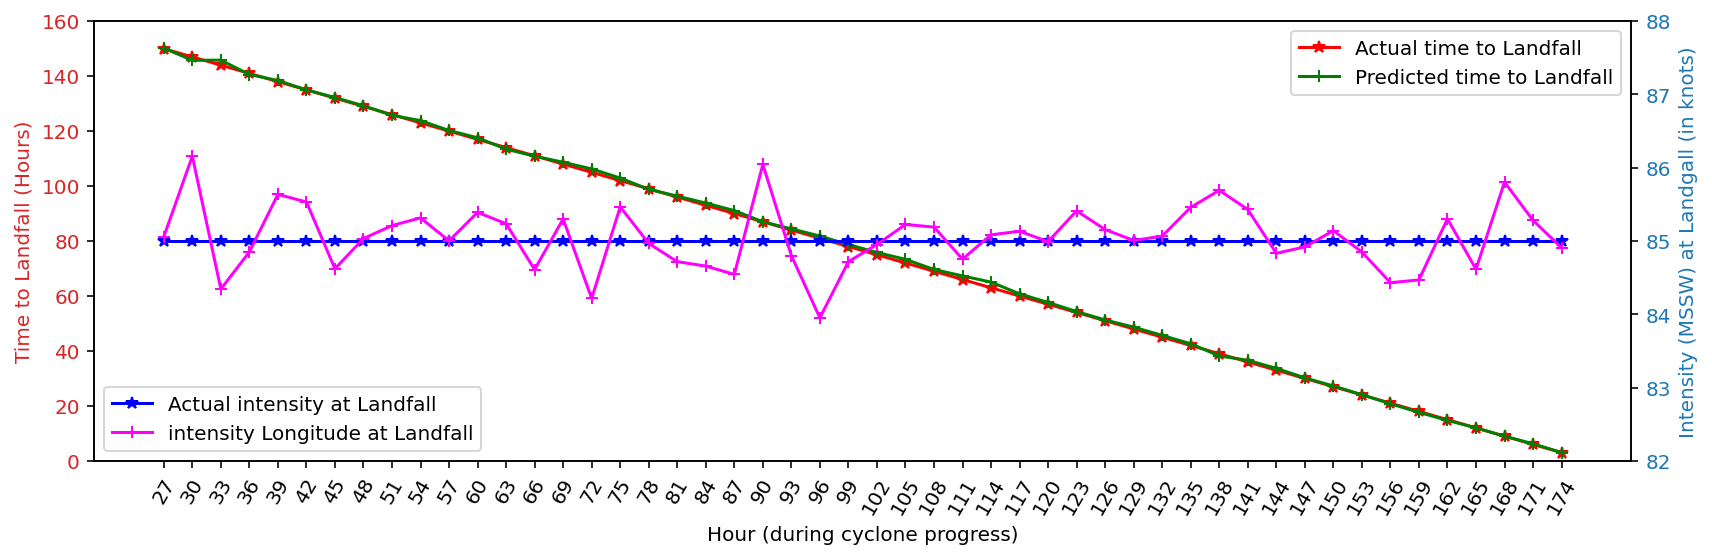

In [ ]:
#Time and Intensity Plot for Fani
print("trainPoints  ", trainPoints)

lengthF = len(yF)

plt.figure(figsize=(10, 10))
fig, ax1 = plt.subplots(figsize=(12, 4))
a = np.linspace(1,lengthF,lengthF)*3 + 8*3

color = 'tab:red'
ax1.set_xlabel('Hour (during cyclone progress)')
ax1.set_ylabel('Time to Landfall (Hours)', color=color)
ax1.plot(a, yF, marker = '*',label = "Actual time to Landfall",color = 'red')
ax1.plot(a, predictionsF, marker = '+',label = "Predicted time to Landfall",color ='green')
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_ticks(a)
plt.xticks(rotation=60)
plt.ylim((0,160))
ax1.legend(loc=1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Intensity (MSSW) at Landgall (in knots)', color=color)  # we already handled the x-label with ax1
ax2.plot(a, yF1, marker = '*',label = "Actual intensity at Landfall",color = 'blue')
ax2.plot(a, predictionsF1, marker = '+',label = "intensity Longitude at Landfall",color='magenta')

ax2.tick_params(axis='y', labelcolor=color)
plt.ylim((82,88))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax2.legend(loc=3)
plt.show()

trainPoints   8


<Figure size 720x720 with 0 Axes>

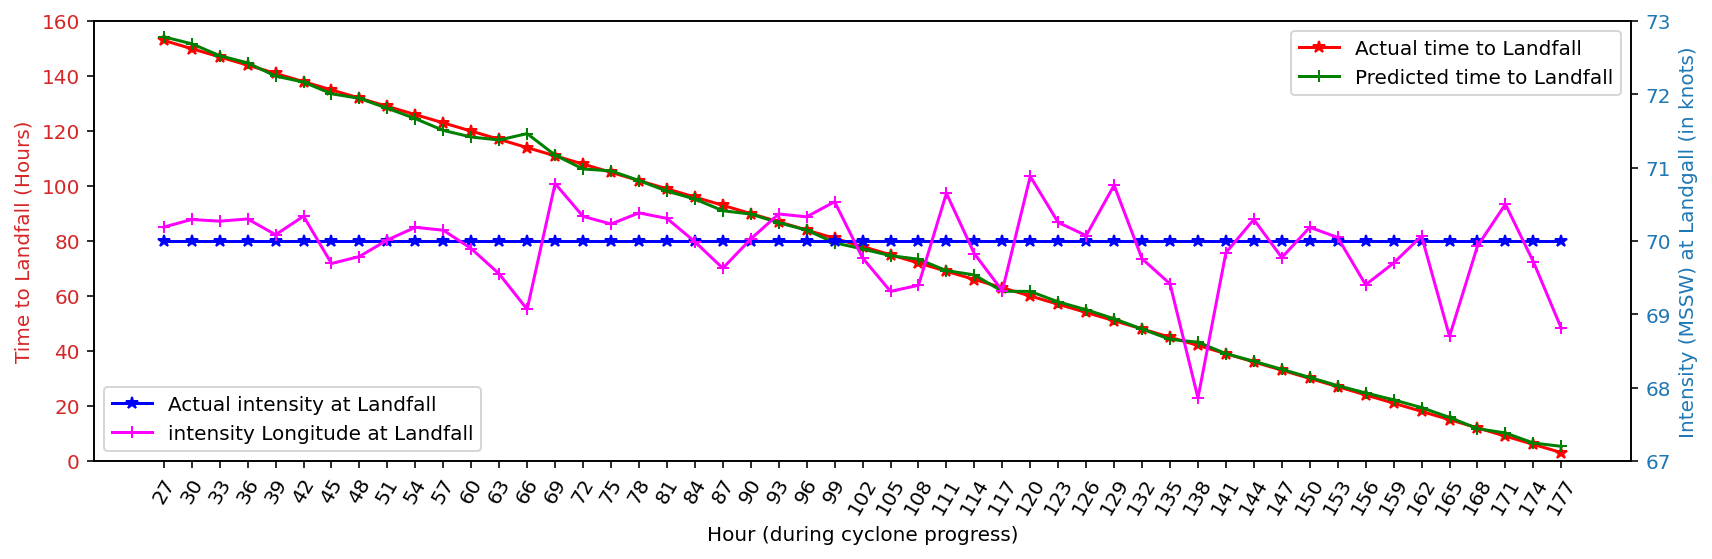

In [ ]:
#Time and Intensity Plot for Gaja
print("trainPoints  ", trainPoints)

lengthG = len(yG)

plt.figure(figsize=(10, 10))
fig, ax1 = plt.subplots(figsize=(12, 4))
a = np.linspace(1,lengthG,lengthG)*3 + 8*3

color = 'tab:red'
ax1.set_xlabel('Hour (during cyclone progress)')
ax1.set_ylabel('Time to Landfall (Hours)', color=color)
ax1.plot(a, yG, marker = '*',label = "Actual time to Landfall",color = 'red')
ax1.plot(a, predictionsG, marker = '+',label = "Predicted time to Landfall",color ='green')
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_ticks(a)
plt.xticks(rotation=60)
plt.ylim((0,160))
ax1.legend(loc=1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Intensity (MSSW) at Landgall (in knots)', color=color)  # we already handled the x-label with ax1
ax2.plot(a, yG1, marker = '*',label = "Actual intensity at Landfall",color = 'blue')
ax2.plot(a, predictionsG1, marker = '+',label = "intensity Longitude at Landfall",color='magenta')

ax2.tick_params(axis='y', labelcolor=color)
plt.ylim((67,73))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax2.legend(loc=3)
plt.show()

trainPoints   8


<Figure size 720x720 with 0 Axes>

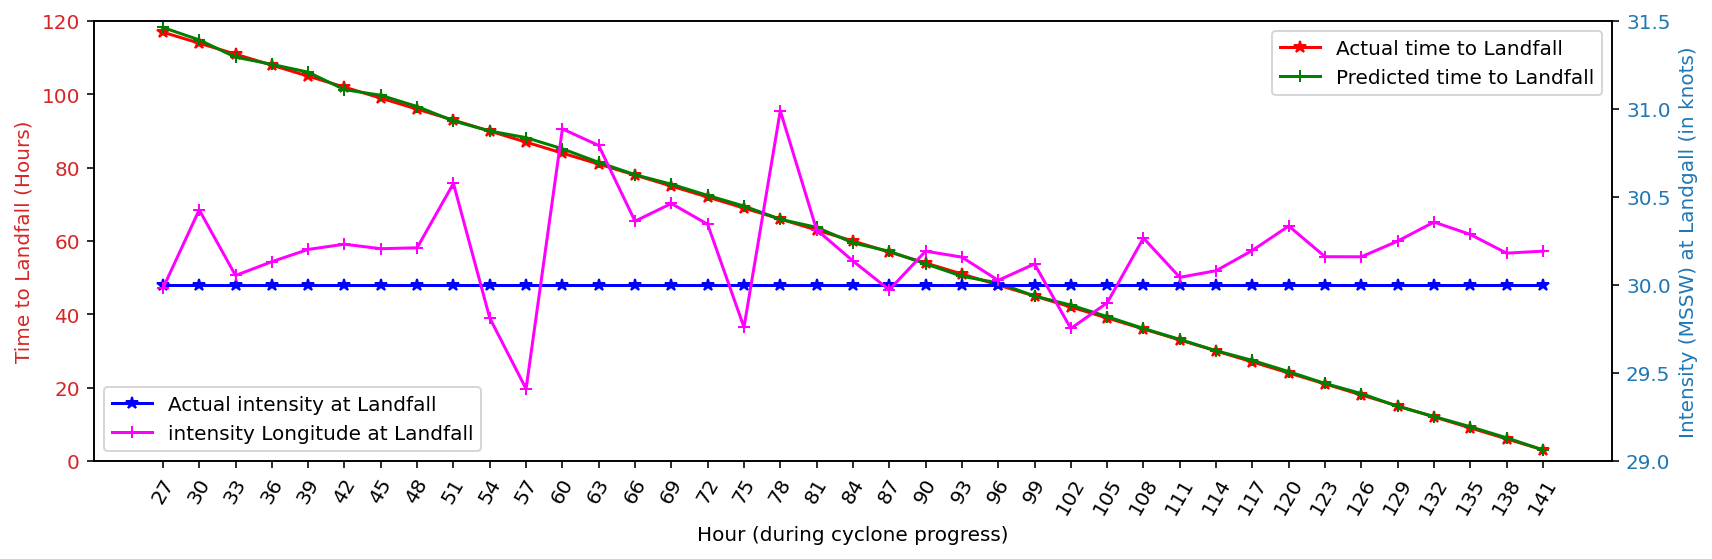

In [ ]:
#Time and Intensity Plot for Bulbul
print("trainPoints  ", trainPoints)

lengthB = len(yB)

plt.figure(figsize=(10, 10))
fig, ax1 = plt.subplots(figsize=(12, 4))
a = np.linspace(1,lengthB,lengthB)*3 + 8*3

color = 'tab:red'
ax1.set_xlabel('Hour (during cyclone progress)')
ax1.set_ylabel('Time to Landfall (Hours)', color=color)
ax1.plot(a, yB, marker = '*',label = "Actual time to Landfall",color = 'red')
ax1.plot(a, predictionsB, marker = '+',label = "Predicted time to Landfall",color ='green')
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_ticks(a)
plt.xticks(rotation=60)
plt.ylim((0,120))
ax1.legend(loc=1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Intensity (MSSW) at Landgall (in knots)', color=color)  # we already handled the x-label with ax1
ax2.plot(a, yB1, marker = '*',label = "Actual intensity at Landfall",color = 'blue')
ax2.plot(a, predictionsB1, marker = '+',label = "intensity Longitude at Landfall",color='magenta')

ax2.tick_params(axis='y', labelcolor=color)
plt.ylim((29,31.5))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax2.legend(loc=3)
plt.show()

In [6]:
#Time to calculate 150 epochs
X, y = load_dataTime(data_pad, 4, feature_count)
X, y = shuffle(X, y, random_state=0)
model = build_model(feature_count, 4)
start = time.time()
model.fit(X, y, batch_size=512, epochs=150, verbose=0, shuffle = True)
end = time.time()
print("time (seconds) ", end-start)

time (seconds)  147.61363768577576


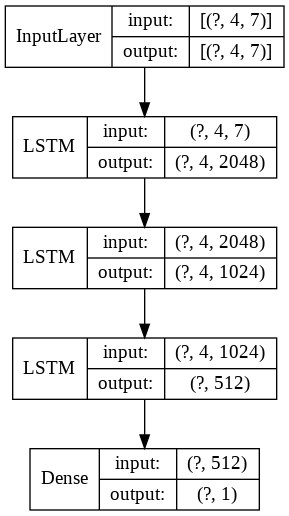

In [5]:
model = build_model(feature_count, 4)
X, y = load_dataTime(data_pad, 4, feature_count)
model.fit(X, y, batch_size=512, epochs=10, verbose=0, shuffle = True)
plot_model(model, to_file='model2.png', show_shapes=True, show_layer_names=False)